In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from typing import Tuple, List, Dict

# Load image

In [ ]:
image_path = 'image.jpg'
try:
    img = mpimg.imread(image_path)
    print(f"Image loaded. Dimensions: {img.shape}")
except FileNotFoundError:
    print(f"Error: '{image_path}' not found. Creating a dummy image.")
    img = np.random.rand(640, 640, 3) * 255
    img = img.astype(np.uint8)

# Check if image is RGB and split channels
if img.ndim == 3 and img.shape[2] == 3:
    R_channel = img[:, :, 0].astype(float) # Convert to float for SVD
    G_channel = img[:, :, 1].astype(float)
    B_channel = img[:, :, 2].astype(float)
    print("RGB channels extracted.")
else:
    print("Image is not RGB. Exiting.")
    exit()

Image loaded. Dimensions: (360, 640, 3)
RGB channels extracted.


Size of channel R: (360, 640)
Size of channel G: (360, 640)
Size of channel B: (360, 640)


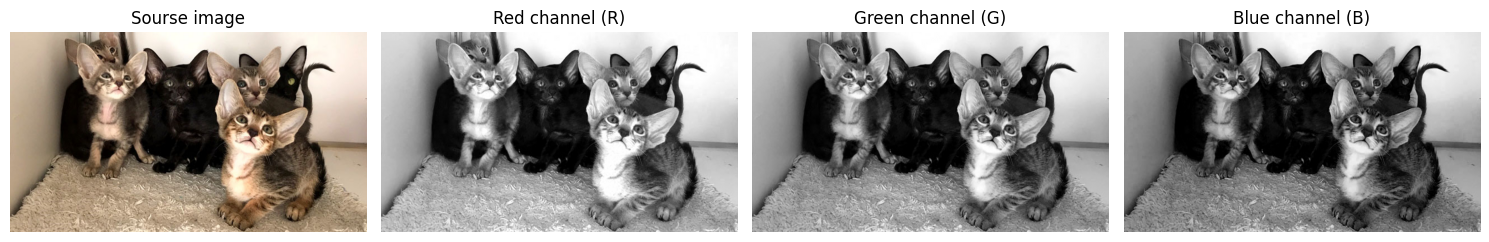


Channels R, G, B have been successfully extracted and are ready for further processing.


In [8]:
if img.ndim == 3 and img.shape[2] == 3:
    R_channel = img[:, :, 0]
    G_channel = img[:, :, 1]
    B_channel = img[:, :, 2]

    print(f"Size of channel R: {R_channel.shape}")
    print(f"Size of channel G: {G_channel.shape}")
    print(f"Size of channel B: {B_channel.shape}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.title('Sourse image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(R_channel, cmap='gray')
    plt.title('Red channel (R)')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(G_channel, cmap='gray')
    plt.title('Green channel (G)')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(B_channel, cmap='gray')
    plt.title('Blue channel (B)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print("\nChannels R, G, B have been successfully extracted and are ready for further processing.")
else:
    print("The image is not RGB (or has different dimensions). Please choose an image with 3 channels.")
    R_channel, G_channel, B_channel = None, None, None


In [11]:
def _run_power_iteration(M: np.ndarray, N: int, initial_vector: np.ndarray) -> Tuple[np.ndarray, float]:
    """
    Performs the power iteration for a given matrix M.
    Returns the dominant eigenvector and its norm.
    """
    v_approx = initial_vector
    for _ in range(N):
        v_approx = M @ v_approx
        norm_v_approx = np.linalg.norm(v_approx)
        if norm_v_approx < 1e-10:
            # Warning: Power method vector became near-zero. Breaking.
            break
        v_approx = v_approx / norm_v_approx
    return v_approx, np.linalg.norm(v_approx)

def _calculate_singular_value_and_u(A: np.ndarray, v: np.ndarray, lambda_val: float, singular_value_idx: int) -> Tuple[float, np.ndarray]:
    """
    Calculates the singular value and the corresponding left singular vector u.
    Handles potential negative eigenvalues.
    """
    if lambda_val < 0:
        print(f"Warning: Negative eigenvalue ({lambda_val:.2e}) encountered for singular value {singular_value_idx}. Taking absolute value.")
        sigma_val = np.sqrt(abs(lambda_val))
    else:
        sigma_val = np.sqrt(lambda_val)

    if sigma_val < 1e-10:
        print(f"Warning: Singular value {singular_value_idx} is near zero ({sigma_val:.2e}). Cannot compute corresponding u vector.")
        return 0.0, np.array([]) # Return 0 and empty array to indicate failure

    u_val = (A @ v) / sigma_val
    # Ensure u_val is normalized
    u_val = u_val / np.linalg.norm(u_val)
    return sigma_val, u_val

def power_method_for_svd(A: np.ndarray, k: int, N: int) -> Tuple[List[float], np.ndarray, np.ndarray]:
    """
    Computes the first k singular values and vectors of matrix A using the power method with deflation.
    Args:
        A: The input matrix (np.ndarray).
        k: The number of singular values/vectors to compute (int).
        N: The number of iterations for the power method (int).
    Returns:
        A tuple containing:
        - singular_values_sorted: A list of singular values, sorted in descending order.
        - U_matrix: The matrix of left singular vectors (np.ndarray).
        - V_T_matrix: The transpose of the matrix of right singular vectors (np.ndarray).
    """
    m, n = A.shape
    singular_values: List[float] = []
    U_vectors: List[np.ndarray] = []
    V_vectors: List[np.ndarray] = []

    A_current = np.copy(A)

    for i in range(k):
        M = A_current.T @ A_current

        # Initialize random vector for power method
        v_approx_initial = np.random.rand(n)
        v_approx_initial = v_approx_initial / np.linalg.norm(v_approx_initial)

        v_approx, final_norm = _run_power_iteration(M, N, v_approx_initial)
        
        if final_norm < 1e-10:
            print(f"Warning: Power method for singular value {i} converged to a near-zero vector. Stopping SVD calculation.")
            break

        # Calculate eigenvalue (sigma_i^2)
        lambda_val = v_approx.T @ M @ v_approx
        
        sigma_val, u_val = _calculate_singular_value_and_u(A_current, v_approx, lambda_val, i)

        if sigma_val == 0.0 and u_val.size == 0: # Check for failure from _calculate_singular_value_and_u
            break

        singular_values.append(sigma_val)
        U_vectors.append(u_val)
        V_vectors.append(v_approx)

        # Deflation
        A_current = A_current - sigma_val * np.outer(u_val, v_approx)

    # Construct U, Sigma, V_T matrices from computed vectors
    if not singular_values:
        return [], np.array([]), np.array([])

    # Sort singular values and corresponding vectors in descending order
    # Create pairs of (singular_value, u_vector, v_vector)
    sorted_components = sorted(zip(singular_values, U_vectors, V_vectors), key=lambda x: x[0], reverse=True)
    
    singular_values_sorted = [comp[0] for comp in sorted_components]
    U_matrix = np.array([comp[1] for comp in sorted_components]).T
    V_matrix = np.array([comp[2] for comp in sorted_components]).T

    return singular_values_sorted, U_matrix, V_matrix.T


# Define number of iterations to test
N_iterations = [10, 50, 100]

# Process each channel
channels = {'R': R_channel, 'G': G_channel, 'B': B_channel}

results: Dict[str, Dict[int, Dict[str, any]]] = {} # Use 'any' for value type for flexibility

for channel_name, channel_matrix in channels.items():
    print(f"\nProcessing {channel_name} channel...")
    m, n = channel_matrix.shape
    # Determine k: number of singular values to compute (min(m, n) for full SVD)
    k_to_compute = min(m, n)
    
    results[channel_name] = {}
    
    for N in N_iterations:
        print(f"  Running SVD for N = {N} iterations...")
        
        # Perform SVD using the power method
        singular_values, U_power, V_T_power = power_method_for_svd(channel_matrix, k_to_compute, N)
        
        # Reconstruct the matrix
        if U_power.size == 0 or V_T_power.size == 0 or not singular_values:
            reconstructed_matrix = np.zeros_like(channel_matrix)
            reconstruction_error_norm = np.inf
            print(f"    SVD failed to compute components for N = {N}. Reconstruction not possible.")
        else:
            Sigma_power = np.diag(singular_values)
            reconstructed_matrix = U_power @ Sigma_power @ V_T_power
            
            # Calculate the norm of the difference
            reconstruction_error_norm = np.linalg.norm(channel_matrix - reconstructed_matrix)
            
            print(f"    Reconstruction error (Frobenius norm) for N = {N}: {reconstruction_error_norm:.4f}")
            
        results[channel_name][N] = {
            'singular_values': singular_values,
            'U': U_power,
            'V_T': V_T_power,
            'reconstruction_error_norm': reconstruction_error_norm
        }

print("\n--- Summary of Results ---")
for channel_name, channel_results in results.items():
    print(f"\nChannel: {channel_name}")
    for N, data in channel_results.items():
        print(f"  N = {N}:")
        print(f"    Number of singular values found: {len(data['singular_values'])}")
        print(f"    Top 5 singular values: {[f'{s:.2f}' for s in data['singular_values'][:5]]}")
        print(f"    Reconstruction Error: {data['reconstruction_error_norm']:.4f}")




Processing R channel...
  Running SVD for N = 10 iterations...
    Reconstruction error (Frobenius norm) for N = 10: 4.0237
  Running SVD for N = 50 iterations...
    Reconstruction error (Frobenius norm) for N = 50: 4.0229
  Running SVD for N = 100 iterations...
    Reconstruction error (Frobenius norm) for N = 100: 4.0229

Processing G channel...
  Running SVD for N = 10 iterations...
    Reconstruction error (Frobenius norm) for N = 10: 3.7853
  Running SVD for N = 50 iterations...
    Reconstruction error (Frobenius norm) for N = 50: 3.7722
  Running SVD for N = 100 iterations...
    Reconstruction error (Frobenius norm) for N = 100: 3.7722

Processing B channel...
  Running SVD for N = 10 iterations...
    Reconstruction error (Frobenius norm) for N = 10: 4.2866
  Running SVD for N = 50 iterations...
    Reconstruction error (Frobenius norm) for N = 50: 4.2431
  Running SVD for N = 100 iterations...
    Reconstruction error (Frobenius norm) for N = 100: 4.2430

--- Summary of Res